<a href="https://colab.research.google.com/github/clint-bg/demos/blob/main/shellandtube/ShellandTubePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shell and Tube Prediction
This sheet is designed to predict the response of a shell and tube heat exchanger given the following input
*   Flow rate through the tube side
*   Incoming temperature of the fluid (tube side)
*   Steam pressure on the shell side
*   Details of the heat exchanger (number of tubes, tube diameter, tube length etc.)

Predicted output will be:
*   Exit temperature of the fluid to be heated



## Heat Exchanger Details
The heat exchanger is a vertically oriented Standard Xchange shell and tube heat exchanger SSCF type and Model number 0314 (3 inch shell diameter and 14 inch tube length). Further details include the number of tubes (56) and the tube size (1/4" outside diameter and 24 BWG 0.022 inches). The baffle spacing on the shell side is either 1.5 or 4 inches depending on the exchanger.

The water flows through the tubes and the steam is on the shell side in contact with the external surface of the tubes.

![My Image](https://github.com/clint-bg/demos/blob/main/shellandtube/shellandtubesscf.png?raw=true)

## Governing Principles
Using empirical correlations for the shell and tube sides of the heat exchanger together with the heat exchanger details, we can estimate the heat imparted to the process fluid (water). From that heat amount and an energy balance, the temperature of the exiting fluid can be estimated. The governing equation for the heat transfer is based on the Log Mean Tempearture Difference (LMTD) approach and is:
$Q = U\cdot A\cdot F\cdot \Delta T_{LM}$

where $U$ is the overall heat transfer coefficient, $A$ is the area, $F$ is a LMTD correction factor based on the heat exchanger type (1 for condensing vapors), and $\Delta T_{LM}$ is the log-mean tempearture difference.  

The heat exchanged is also equal to the energy picked up by the fluid (water) after passing through the exchanger and is equivalent to:
$Q = \dot{m}\cdot C_p\cdot \Delta T$

where $\dot{m}$ is the mass flow, $C_p$ is the heat capacity, and $\Delta T$ is the change in temperature.

## Helpful resources
The NCEES Handbook for the chemical engineering exams is very helpful. It can be downloaded for free from the NCEES website after registering with them. See https://help.ncees.org/article/87-ncees-exam-reference-handbooks. Of course other resources can be used for the engineering principles, empirical correlations, and hueristics. The images with the equations and drawings here are directly from the NCEES Handbook for chemical engineering.

In [1]:
#import needed packages
import numpy as np
from scipy.optimize import fsolve
from scipy import stats
import matplotlib.pyplot as plt

### Property data for water

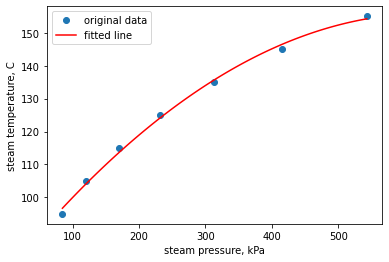

In [2]:
heatcapacity =  4182 #J/kg/K
thermalconductivity = 0.598 #W/m/K
viscosity = 0.0004 #Pa*s estimated at 70 C
density = 997 #kg/m3
heatofvaporization = 2.257E6 # J/g
#steam temperature as a function of pressure given pressure in units of psig
steampressuredata = [84.55,120.82,169.06,232.1,313.0, 415.4,543.1] #kPa
steamtemperaturedata = [95,105,115,125,135,145,155] #degrees C
z = np.polyfit(steampressuredata, steamtemperaturedata, 2)
plt.plot(steampressuredata, steamtemperaturedata, 'o', label='original data')
xlin = np.linspace(min(steampressuredata), max(steampressuredata), 100)
ylin = z[2] + z[1]*xlin + z[0]*xlin**2
plt.plot(xlin, ylin, 'r', label='fitted line'); plt.xlabel("steam pressure, kPa"); plt.ylabel("steam temperature, C")
plt.legend(); plt.show()
def steamtemp(pressure=10): #returns C from psig
  kpapressurea = (pressure + 12.5)*6.895 #convert from gauge pressure in psi to absolute in kPa
  return z[2] + z[1]*kpapressurea + z[0]*kpapressurea**2


### Properties of the heat exchanger


In [3]:
tubeod = 0.25*0.0254 #1/4 inches to meters
wallthickness = 0.022*0.0254 #24 BWG
wallthermalconductivity = 45 #W/m/K
tubeid = tubeod - wallthickness # m
numberoftubes = 56
tubelength = 14*0.0254 #m
tubebafflelength = 1.5*0.0254 #m
surfacearea = numberoftubes*np.pi*tubeod*tubelength # This is the total surface area of the tubes (outside)

## Approach
The approach in this writeup is to first give an **rough expected range** for the exit temperature based on some hueristics for the overall heat transfer coefficient. After that, the nitty-gritty correlations will be used to get a better estimate we'll call **the narrowed-in estimate**.

In [4]:
#define flow rate through the heat exchanger in gallons per minute
flowgpm = 20 #gallons per minute
massflow = flowgpm/264.2*density/60 #convert to SI units in kg/sec
#defline steam pressure
steampressurepsig = 10
#define inlet temperature
inlettemp = 25 #C

### Rough Expected Range
This is a back-of-the-envelop estimate. There are engineering expected ranges for variables that can be effectively used to narrow in on the answer. Doing so can be very useful in understanding the problem and getting a feel for the outcome and expected results. It sometimes can be very easy to dive deeply into a problem and get lost with mistakes easily derailing your complex analysis. Doing a back-of-the-envelope estimate can help with that.

Equation to solve: $\dot{m}\cdot C_p\cdot (T_{out}-T_{in}) = U\cdot A\cdot (T_{out} - T_{in})/ln((T_{cond}-T_{in})/(T_{cond}-T_{out}))$

![My Image](https://github.com/clint-bg/demos/blob/main/shellandtube/condensationlmtd.png?raw=true) 

#### Overall heat transfer coefficient Range
From the NCEES Handbook on Page 188, there's a table that is titled: Typical Overall Heat-Transfer Coefficients in Heaters (Shell and Tube) with Condensing Steam. In that table, for a heated fluid of water, the heat transfer coefficient is 1500-4000 W/m2/K. Based on that and a given condition (flow rate and the intial fluid temperature and the steam temperature/pressure) the exit temperature can be found.

In [5]:
overallU = [1500,4000]

In [6]:
#define equation to solve given the overall heat transfer coefficient
def func(x,*U):
  Tcond = steamtemp(steampressurepsig)
  return U[0]*surfacearea*(x-inlettemp)/np.log((Tcond-inlettemp)/(Tcond-x))-massflow*heatcapacity*(x-inlettemp)

In [7]:
#now solve for the outlet temperature range
outlettemprange = []
for U in overallU:
  outlettemprange.append(fsolve(func,inlettemp+30,args=(U))[0])
print(f"So given a flow rate of {flowgpm} gpm, an inlet temperature of {inlettemp:.1f} C, and steam pressure of {steampressurepsig} psig, the expected outlet temperature is between {outlettemprange[0]:.1f} and {outlettemprange[1]:.1f} C")

So given a flow rate of 20 gpm, an inlet temperature of 25.0 C, and steam pressure of 10 psig, the expected outlet temperature is between 34.2 and 47.4 C


### The Narrowed-In Estimate
Using the results from the Rough Expected Range estimate above, further analysis can be completed to get a better estimate. Those calculations are completed here. We'll first estimate the tube side and shell side heat transfer coefficients from empirical correlations.

#### Tube side heat transfer coefficient
Most correlations are functions of the Reynolds and Prandlt numbers so we'll calculate those first.

In [8]:
fluidvelocity = massflow/density/(numberoftubes*np.pi/4*tubeid**2) #velocity of the fluid in m/s
Re = density*tubeid*fluidvelocity/viscosity #Reynolds number
Pr = heatcapacity*viscosity/thermalconductivity
Re,Pr

(12346.237497701488, 2.7973244147157192)

The correlation for turbulent flow inside a circular pipe for the Nusselt number can be found on Page 150 of the NCEES Handbook and is below.

In [9]:
insideNu = 0.023*(Re**0.8)*(Pr**0.33) #will assume the ratio in the viscosity at the tube interior vs the surface raised to the 0.14 power is close to 1
insideh = insideNu*thermalconductivity/tubeid
insideh # W/m2/K

6256.238460841464

#### Shell side heat transfer coefficient
Condensing steam on a vertical surface, assumed laminar. The associated Nusselt number correlation is on Page 163 of the NCEES Handbook.

In [18]:
outsideNu = 0.943*(((density**2)*9.81*heatofvaporization*tubebafflelength**3)/(viscosity*thermalconductivity*(10)))**0.25 #difference between the surface temperature and saturated steam temperature estimated to be 10 C (per the NCEES handbook its between 3 and 22)
outsideh = outsideNu*thermalconductivity/tubebafflelength
outsideh

12500.836060338457

#### Overall heat transfer coefficient
The overall heat transfer coefficient is an inverse sum of the individual heat transfer coefficients including the thermal conductivity of the tube as given on Page 164 of the NCEES Handbook.

In [19]:
Uov = 1/(1/insideh*tubeod/tubeid + tubeod/2/wallthermalconductivity*np.log(tubeod/tubeid) + 1/outsideh) #assuming no fouling
print(f'So the overall heat transfer coefficient, without fouling, is {Uov:.0f} which is in the range estimated above')

So the overall heat transfer coefficient, without fouling, is 3820 which is in the range estimated above


##### Including Fouling
The NCEES handbook gives representative fouling factors in Section 4.4.1.5 on Page 190 which is partially reproduced below.

![My Image](https://github.com/clint-bg/demos/blob/main/shellandtube/foulingfactors.png?raw=true) 

In [22]:
Uovwithfouling = 1/(1/Uov + 0.0005*tubeod/tubeid) #assuming the shell side fouling is effectively zero (clean steam)
Uovwithfouling

1234.563076670487

In [25]:
#now solve for the outlet temperature range
outlettemprange = []
for U in [Uovwithfouling,Uov]:
  outlettemprange.append(fsolve(func,inlettemp+30,args=(U))[0])
print(f"So given a flow rate of {flowgpm} gpm, an inlet temperature of {inlettemp:.1f} C, and steam pressure of {steampressurepsig} psig, the expected outlet temperature is between {outlettemprange[0]:.1f} and {outlettemprange[1]:.1f} C including and not including fouling, respectively.")

So given a flow rate of 20 gpm, an inlet temperature of 25.0 C, and steam pressure of 10 psig, the expected outlet temperature is between 32.6 and 46.5 C including and not including fouling, respectively.


Note that the range of temperatures expected with and without fouling is approximately the same as the range for the estimate overal heat transfer coefficient range given above.